# Example 7-1 Monte Carlo simulations of wind speeds
# Question 1: Use the definition of the auto-spectral density of the u turbulence component and generate time series of wind velcities 
### Define auto-spectral density
In this example, we will simulate time series of turbulent wind using the definition of the auto-spectral density of turbulence from the Norwegian regulations for bridge design N400. The auto spectral density is defined by

$$\frac{S_u(f)f}{\sigma_u^2} = \frac{Au \hat{f}_u}{\left(1+ 1.5 Au \hat{f}_u  \right)^{\frac{5}{3}}} $$

The reduced frequency is defined as

$$\hat{f}_u = \frac{f {}^xL_u}{V}  $$

We need to convert the auto-spectral density to a function of the frequency in rad/s. The area under the auto spectral density needs to stay the same. This implies that the following relation applies:

$$S_u(f) = 2\pi S_u(\omega) $$

We also introduce the reduced frequency:

$$ \hat{\omega}_u = \frac{\omega {}^xL_u}{V}$$

The following relation apply:

$$\hat{\omega}_u = 2\pi \hat{f}_u $$

The auto-spectral density is thus defined as

$$\frac{S_u(\omega)\omega}{\sigma_u^2} = \frac{ \frac{Au}{2\pi} \hat{\omega}_u}{\left(1+ 1.5 \frac{Au}{2\pi} \hat{\omega}_u  \right)^{\frac{5}{3}}} $$

Here $A_u = 6.8$. We also need the turbulence intensity and the integral length scale. We assume that the turbulence intensity is $I_u = 0.15$. The integral length scale is defined by

$$ ^xL_u = L_1 \left(\frac{z}{z_1}\right)^{0.3} $$

Here $L_1=100$, $z_1 = 10$ and $z=50$

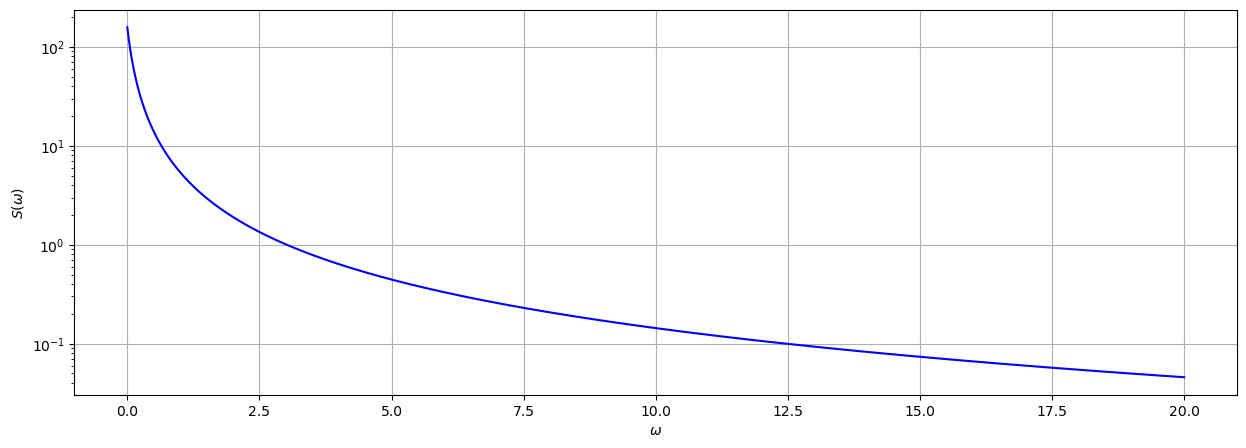

In [39]:
# The auto spectral density of the u-comp according to N400
import numpy as np
from matplotlib import pyplot as plt
w = np.linspace(0,20,10000);
z=50.0; #Height above ground,
z1=10.0;  #Reference height
L1=100.0;  #Reference integral length scale z1=10; L1=100;
xLu=L1*(z/z1)**0.3; # Integral length scale
Au=6.8/2/np.pi; # Constant in the auto-spectral density
V=40;   #Mean wind velocity
Iu=0.15;# Turbulence intensity
Su = (Iu*V)**2*Au*xLu/V/((1+1.5*Au*w*xLu/V)**(5.0/3.0));
  
plt.figure(figsize=(15,5))    
plt.plot(w,Su,'-',color='b')
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.grid()
#plt.xscale('log')
plt.yscale('log')

 ### Simulate time series from auto-spectral density
The following formula can obtain realizations of the stochastic process.

$$x(t) = \sum_{n=1}^{N}  A_k \cos (\omega_kt + \phi_k) $$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$

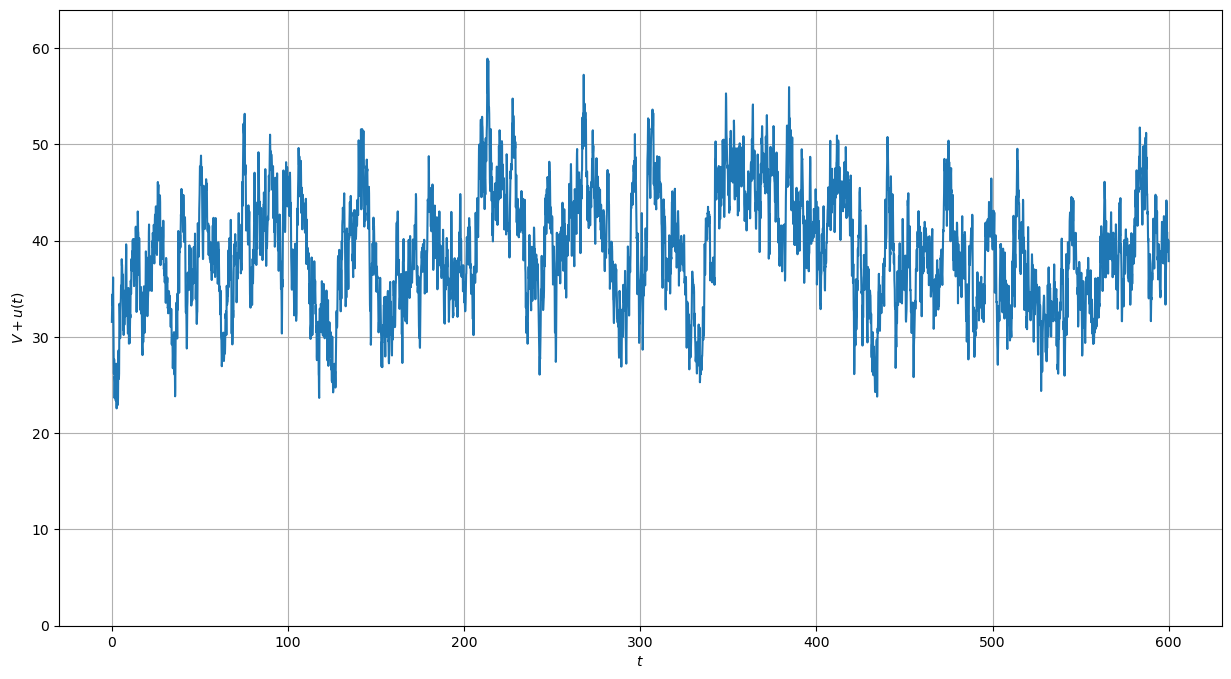

In [35]:
phi = np.random.rand(w.shape[0])*2*np.pi # Random phase angles 
t = np.linspace(0,600,6000) # Time vector
u = np.zeros(t.shape[0]) # Initialize the vector of x values
domega = w[1]-w[0] # Frequency spacing
for k in range(w.shape[0]):
    Ak = (2*Su[k]*domega)**0.5 #Amplitude
    u = u + Ak * np.cos(w[k]*t+ phi[k]) # Sum the contibution from each harmonic component
    
plt.figure(figsize=(15,8))
plt.plot(t,u+V);
plt.ylabel(r'$V+u(t)$')
plt.xlabel(r'$t$')
plt.ylim(0, V*(1+4*Iu))
plt.grid()

### Re-estimate the spectral density

Let's estimate the spectrum of this time series using the Welch method and compare with the target spectrum.


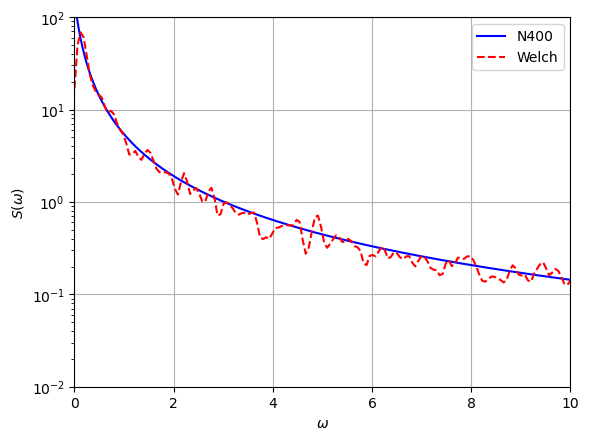

In [36]:
import scipy

Ndivisions=10 # Number of divisions of the time series
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window
Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2

# Spectral matrix
S_welch=np.zeros((2,2,np.int32(Nfft_pow2/2+1)),dtype=np.complex_)

dt=t[1]-t[0]

f_welch, S_Hz=scipy.signal.csd(u,u, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
w_welch=f_welch*2*np.pi # Frequency axis in rad/s
S_welch=S_Hz/(2*np.pi) # Spectrum in rad/s
    
# Plot spectrum
plt.figure()    
plt.plot(w,Su,'-',color='b',label='N400')  
plt.plot(w_welch,S_welch,'--',color='r',label='Welch')  
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.grid()
plt.xlim(0,10)
plt.ylim(1e-2,1e2)
#plt.xscale('log')
plt.yscale('log')
plt.legend()

### Calculate statistics

Let's calculate the statistics and compare with what we specified for the simulation.


In [37]:
u_mean=np.mean(u+V)
u_std=np.std(u+V)

ti=u_std/u_mean*100 # Turbulence intensity in percent

print('Mean is ' + str(round(u_mean*100)/100) + ' m/s' )


print('Turbulence intensity is ' + str(round(ti*100)/100) + ' %' )


Mean is 38.95 m/s
Turbulence intensity is 15.2 %
